In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [2]:
from utils.imports import *

In [43]:
from pos import *

In [4]:
tagger = POSTagger()

In [6]:
fn_corpora = Path('datasets/北大人民日报语料库.txt')

In [48]:
sentence_splits[0]

['迈向',
 '充满',
 '希望',
 '的',
 '新',
 '世纪',
 '——',
 '一九九八年',
 '新年',
 '讲话',
 '（',
 '附',
 '图片',
 '１',
 '张',
 '）']

In [52]:
# raw_corpora = tagger.create_dataset(fn_corpora, fn_corpora.parent/'features')
# sentences_space = tagger.create_dataset(fn_corpora, fn_corpora.parent/'features')
# sentence_splits, poses = tagger.create_dataset(fn_corpora, fn_corpora.parent/'features')
X, y = tagger.create_dataset(fn_corpora, fn_corpora.parent/'features')

In [55]:
tagger.create_dataset(fn_corpora, fn_corpora.parent)

Features saved to datasets/pos北大人民日报语料库_features.


In [80]:
import pycrfsuite
import string
printable = set(string.printable)

trainer = pycrfsuite.Trainer(verbose=False)
for xseq, yseq in zip(X, y):
    yseq = [''.join(filter(lambda x: x in string.printable, o)).strip() for o in yseq]
    trainer.append(xseq, yseq)
trainer.set_params({
    'c1': 1.0, 
    'c2': 1e-3,
    'max_iterations': 60,
    'feature.possible_transitions': True
})


# trainer.train('pos1.crfsuite')

In [81]:
trainer.train('pos1.crfsuite')

In [82]:
tagger = pycrfsuite.Tagger()
# tagger.open('3-2-1e-3-gram-120.crfsuite')
tagger.open('pos1.crfsuite')

In [85]:
features = np.load('datasets/pos北大人民日报语料库_features.npz')

In [86]:
X_test, y_test = features['X_test'], features['y_test']

In [97]:
y_pred = [tagger.tag(o) for o in X_test]

In [ ]:
average_precision_score(y_true, y_pred)

In [100]:
from sklearn.metrics import average_precision_score
y_true = y_test
print(average_precision_score(y_true, y_pred))

ValueError: You appear to be using a legacy multi-label data representation. Sequence of sequences are no longer supported; use a binary array or sparse matrix instead.

In [121]:
# Use label_binarize to be multi-label like settings
y_test_flat = np.array([o for y in y_test for o in y])
y_score_flat = np.array([o for y in y_pred for o in y])
classes = np.unique(np.array(y_test_flat))
y_test_flat, y_score_flat = (label_binarize(o, classes=classes) for o in (y_test_flat, y_score_flat))
n_classes = Y.shape[1]

In [134]:
from sklearn.preprocessing import label_binarize
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score
    
def eval_mult_class(Y_test, y_score):
    # For each class
    precision = dict()
    recall = dict()
    average_precision = dict()
    for i in range(n_classes):
        precision[i], recall[i], _ = precision_recall_curve(Y_test[:, i],
                                                            y_score[:, i])
        average_precision[i] = average_precision_score(Y_test[:, i], y_score[:, i])

    # A "micro-average": quantifying score on all classes jointly
    precision["micro"], recall["micro"], _ = precision_recall_curve(Y_test.ravel(),
        y_score.ravel())
    average_precision["micro"] = average_precision_score(Y_test, y_score,
                                                         average="micro")
    print('Average precision score, micro-averaged over all classes: {0:0.2f}'
          .format(average_precision["micro"]))
    return precision, recall, average_precision

In [135]:
precision, recall, average_precision = eval_mult_class(y_test_flat, y_score_flat)

Average precision score, micro-averaged over all classes: 0.87


In [149]:
pd.DataFrame(list(zip([o[1][5:] for o in X_test[0]], y_pred[0], y_true[0])), columns=['词', '预测词性', '标注词性'])

,词,预测词性,标注词性
0,为了,p,p
1,全面,ad,ad
2,贯彻,v,v
3,江,nr,nr
4,泽民,nr,nr
5,同志,n,n
6,提出,v,v
7,的,u,u
8,八字,n,n
9,方针,n,n


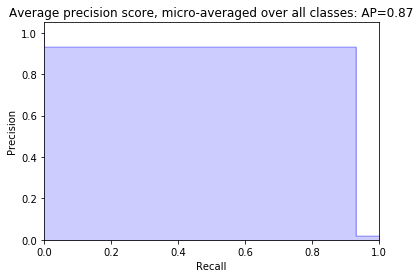

In [137]:
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score
from sklearn.utils.fixes import signature

def plot_mult_class(precision, recall, average_precision):
    plt.figure()
    plt.step(recall['micro'], precision['micro'], color='b', alpha=0.2,
             where='post')
    step_kwargs = ({'step': 'post'}
               if 'step' in signature(plt.fill_between).parameters
               else {})
    plt.fill_between(recall["micro"], precision["micro"], alpha=0.2, color='b',
                     **step_kwargs)

    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.ylim([0.0, 1.05])
    plt.xlim([0.0, 1.0])
    plt.title(
        'Average precision score, micro-averaged over all classes: AP={0:0.2f}'
        .format(average_precision["micro"]))
plot_mult_class(precision, recall, average_precision)